In [137]:
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

In [138]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam , RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras

In [139]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [140]:
tf.test.is_built_with_cuda()

True

In [141]:
print(tf.version.VERSION)

2.6.0


In [142]:
tf.test.is_gpu_available()

True

## 1. Load dữ liệu

In [143]:
# Đọc file các caption
def load_cap(filename):
    file = open(filename, 'r', encoding='utf-8')
    text = file.read()
    file.close()
    return text
filename = "data/Flickr8k/Flickr8k_text/Flickr8k.token_VN.txt"

doc = load_cap(filename)

In [144]:
# Lưu img và caption dưới dạng dict
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping
descriptions = load_descriptions(doc)
descriptions['1000268201_693b08cb0e']

['Một đứa trẻ mặc váy hồng đang leo lên cầu thang ở lối vào .',
 'Một cô gái đi vào tòa nhà bằng gỗ .',
 'Một bé gái trèo vào nhà chơi bằng gỗ .',
 'Một bé gái đang leo cầu thang đến nhà vui chơi của mình.',
 'Một cô bé mặc váy hồng đi vào căn nhà gỗ .']

## 2. Xử lý dữ liệu

#### 2.1 Xử lý ảnh

In [145]:
# Lấy id ảnh tương ứng với dữ liệu train, test, dev
def import_id_img(filename):
    doc = load_cap(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

filename = 'data/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train = import_id_img(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [146]:
images = 'data/Flickr8k/Flicker8k_Dataset/'

In [147]:
#Lấy lấy các ảnh jpg trong thư mục
img = glob.glob(images + '*.jpg')

In [148]:
#train image
train_images_file = 'data/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Tạo danh sách tất cả các hình ảnh train với full path
train_img = []
for i in img: 
    if i[len(images):] in train_images: 
        train_img.append(i) 

In [149]:
#test image
test_images_file = 'data/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Tạo danh sách tất cả các hình ảnh test với full path
test_img = []
for i in img: 
    if i[len(images):] in test_images: 
        test_img.append(i) 

In [150]:
# Load ảnh resize ảnh về khích thước input của InceptionV3 
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [151]:
model = InceptionV3(weights='imagenet')
# tạo model mới bỏ layer cuối từ inception v3
model_new = Model(model.input, model.layers[-2].output)

In [152]:
# encode image
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [153]:
# encode các ảnh trong train set
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 367.5756940841675


In [154]:
# encode các ảnh trong test set
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 61.97434997558594


In [159]:
train_features = encoding_train
len(train_features)

6000

#### 2.2 Xử lý văn bản

In [160]:
#Xử lý văn bản (làm sạch)
def word_clean(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)
word_clean(descriptions)
descriptions['1000268201_693b08cb0e']

['một đứa trẻ mặc váy hồng đang leo lên cầu thang lối vào',
 'một cô gái đi vào tòa nhà bằng gỗ',
 'một bé gái trèo vào nhà chơi bằng gỗ',
 'một bé gái đang leo cầu thang đến nhà vui chơi của mình',
 'một cô bé mặc váy hồng đi vào căn nhà gỗ']

In [161]:
# Lưu description xuống file
def save_word(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w', encoding='utf-8')
    file.write(data)
    file.close()
save_word(descriptions, 'descriptions.txt')

In [162]:
# Thêm 'startseq', 'endseq' cho chuỗi
def load_clean_descriptions(filename, dataset):
    doc = load_cap(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)

In [163]:
# Tạo list các train caption
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)

29981

In [164]:
# Đếm và lấy các từ trên 10 lần
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

Số từ còn lại sau khi lấy các từ trên 10 lần 3129 -> 1366

In [166]:
# build i2w và w2i
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [167]:
vocab_size = len(ixtoword) + 1 
vocab_size

1367

In [168]:
# chuyển đổi từ điển mô tả thành danh sách mô tả, tính toán độ dài của mô tả với từ nhiều nhất
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)
print(len(train_descriptions))
print('độ dài của description: %d' % max_length)

5997
độ dài của description: 46


In [169]:
# hàm data generator 
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0

In [171]:
# Load Glove model
glove_dir = 'data/glove/'
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [172]:
#xây dựng embedding matrix 
embedding_dim = 200

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [173]:
embedding_matrix.shape

(1367, 200)

## 3. Model

In [174]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [175]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 46)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 46, 200)      273400      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

In [176]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [177]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [178]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [179]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

999/999 [==============================] - 132s 132ms/step - loss: 3.4514


In [357]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

####  Dự đoán

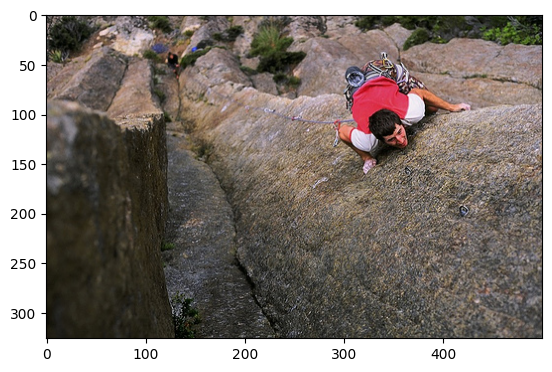

In [291]:
z = 99
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [294]:
predict = greedySearch(image)
predict

'một người đàn ông mặc áo sơ mi đỏ đang trên tảng đá'

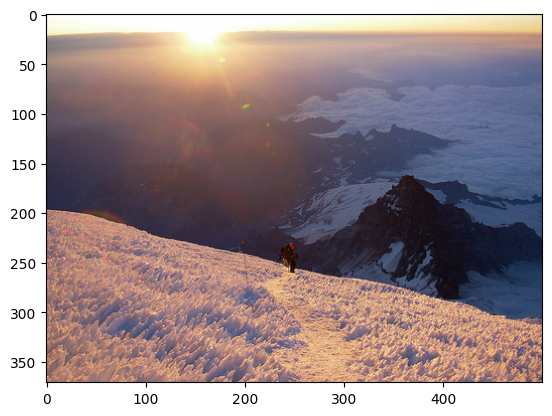

In [296]:
z = 168
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images + pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [297]:
predict = greedySearch(image)
predict

'một người đàn ông đang trên đỉnh núi'

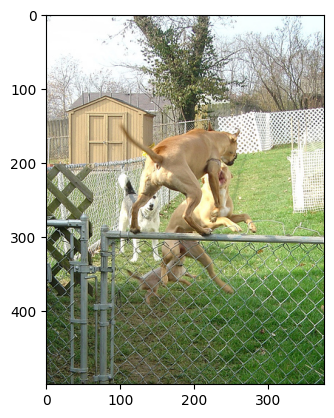

In [299]:
z = 442
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [300]:
predict = greedySearch(image)
predict

'một con chó màu nâu nhảy qua chướng ngại'

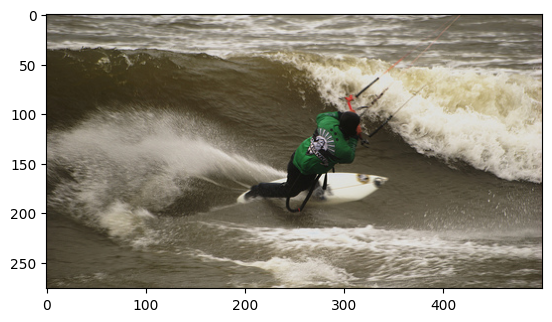

In [301]:
z = 485
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [302]:
predict = greedySearch(image)
predict

'một người đàn ông đang trên sóng nước'

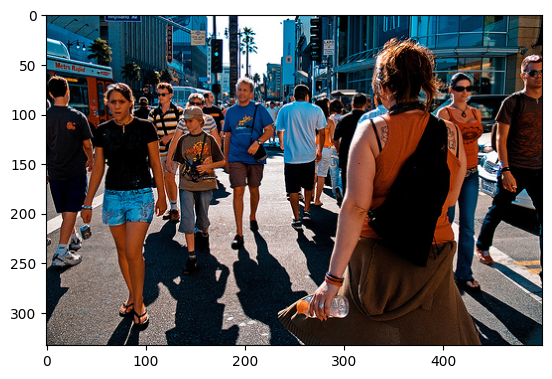

In [321]:
z = 15
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [318]:
predict = greedySearch(image)
predict

'một nhóm người đang đi bộ dưới đường phố'

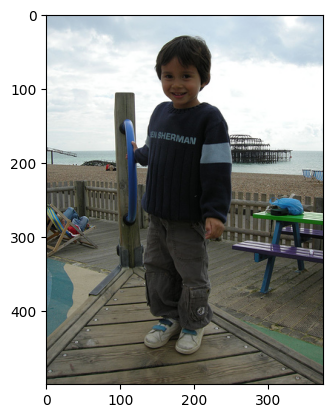

In [323]:
z = 55
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [324]:
predict = greedySearch(image)
predict

'một cậu bé đang cười'

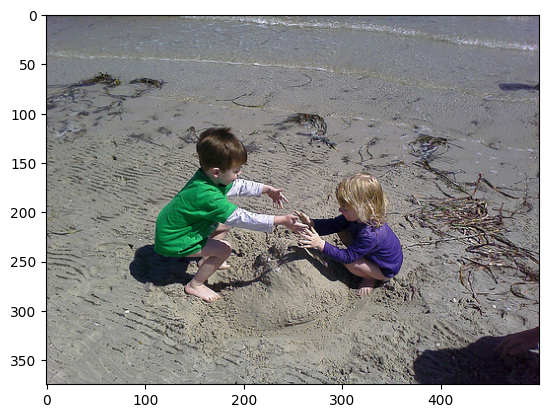

In [330]:
z = 150
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [331]:
predict = greedySearch(image)
predict 

'hai cậu bé đang chơi cát'

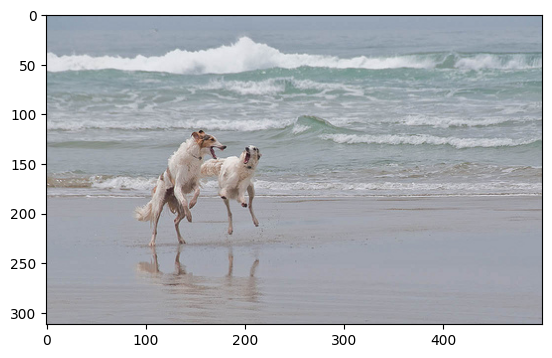

In [334]:
z = 800
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [335]:
predict = greedySearch(image)
predict 

'hai con chó đang chạy trên biển'

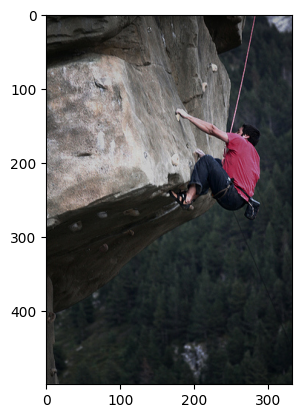

In [344]:
z = 999
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [345]:
predict = greedySearch(image)
predict 

'một người đàn ông mặc áo đỏ đang leo núi'

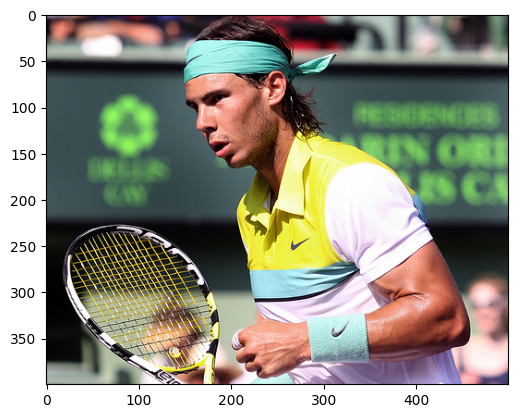

In [349]:
z = 699
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [350]:
predict = greedySearch(image)
predict 

'một cầu thủ quần vợt'

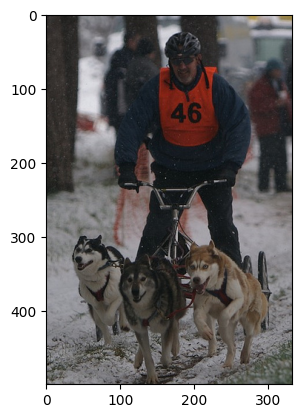

In [355]:
z = 209
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [356]:
predict = greedySearch(image)
predict 

'một đàn chó đang kéo người đàn ông mặc áo màu đỏ'

#### Một số dự đoán bị lỗi

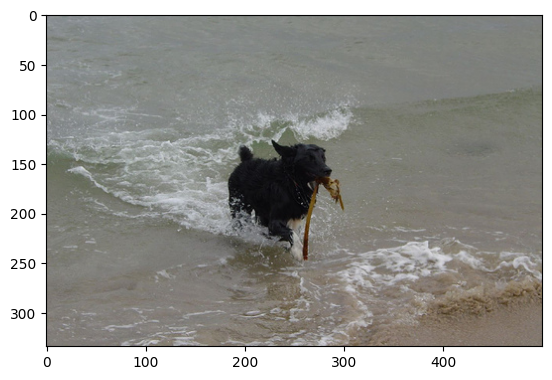

In [358]:
z = 47
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [359]:
predict = greedySearch(image)
predict 

'một con chó đen chạy chạy trên nước'

-> lặp từ

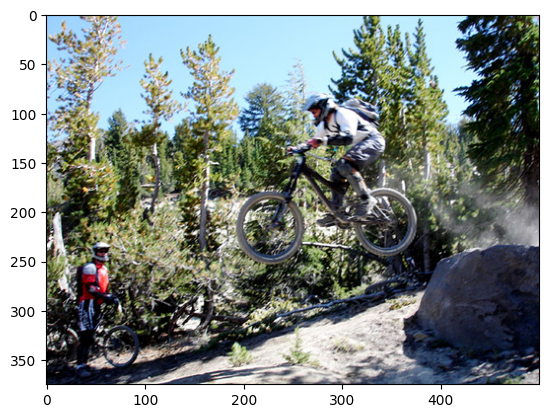

In [360]:
z = 40
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [361]:
predict = greedySearch(image)
predict 

'một người đàn ông đi xe đạp địa xe đạp địa'

-> lặp từ

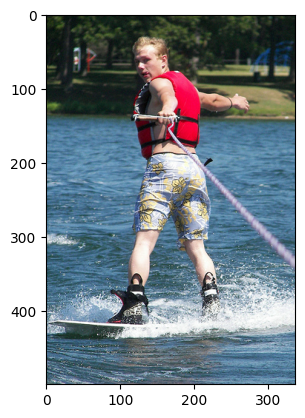

In [362]:
z = 88 
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [363]:
predict = greedySearch(image)
predict 

'một người đàn ông mặc đồ trên nước'

-> nghĩa chưa đủ

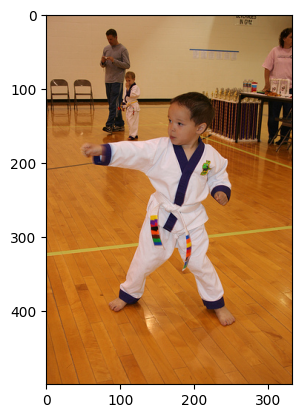

In [366]:
z = 260 
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [367]:
predict = greedySearch(image)
predict 

'một cậu bé mặc áo sơ mi trắng và trắng mũ đang đang'

-> không rõ nghĩa

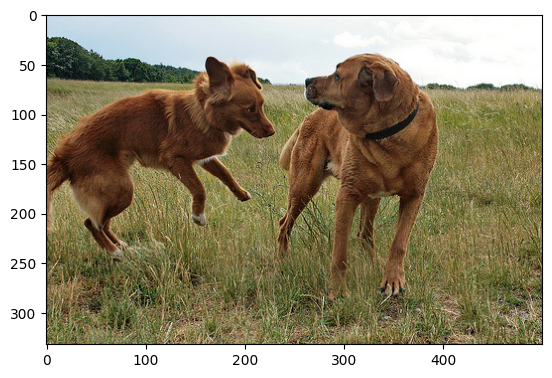

In [377]:
z = 305
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [378]:
predict = greedySearch(image)
predict 

'một con chó màu nâu nâu trên một con chó màu nâu'

-> không rõ nghĩa

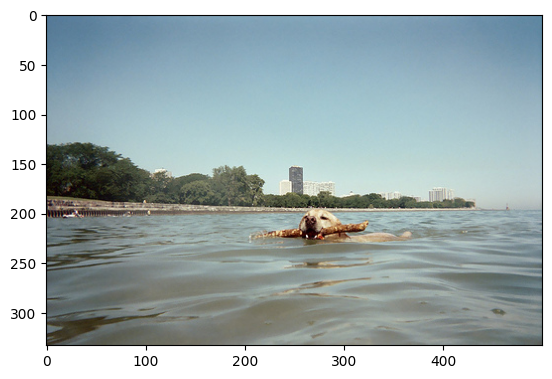

In [381]:
z = 400
list_img = list(encoding_test.keys())
pic = list_img[z]
img = images+ pic
x = plt.imread(img)
sss = plt.imread(images+pic)
plt.imshow(sss)
image = encoding_test[pic].reshape((1,2048))

In [382]:
predict = greedySearch(image)
predict 

'một con chó màu nâu bơi nước'

-> không rõ nghĩa

### 4. Độ đo, đánh giá

In [449]:
def load_clean_descriptions_test(filename, dataset):
    # load document
    doc = load_cap(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = ' '.join(image_desc) 
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [450]:
filename_test = 'data/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'

In [451]:
test = import_id_img(filename_test)

In [452]:
print('Dataset: %d' % len(test))

Dataset: 1000


In [453]:
test_descriptions = load_clean_descriptions_test('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [454]:
test_descriptions['3458211052_bb73084398']

['một đám đông đang xem cuộc đua xe đạp địa hình',
 'một nhóm người bên lề một cuộc đua atv',
 'một dòng người nhìn chằm chằm vào những chiếc xe trên con đường đất',
 'một hàng khán giả tại một cuộc đua',
 'người đứng hàng rào xem xe cơ giới trên cánh đồng']

In [455]:
import  nltk.translate.bleu_score as bleu

In [456]:
from nltk.translate.bleu_score import sentence_bleu

In [457]:
def bleu_score(predict,actual):
    predict_split= predict.split()
    list_actual_one = []
    for i in range(0,5):
        list_actual_one.append(actual[i].split())
    a = sentence_bleu(list_actual_one, predict_split,weights=(1, 0, 0, 0))
    return a

In [458]:
def blue_score_all(list_img,encoding_test):
    sum = 0
    for i in range(len(list_img)):
        list_img = list(encoding_test.keys())
        pic = list_img[i]
        image = encoding_test[pic].reshape((1,2048))
        predict = greedySearch(image)
        pci_rm_jpg = pic.replace('.jpg','')
        actual = test_descriptions[pci_rm_jpg]
        sum += bleu_score(predict,actual)
    return sum

In [459]:
bleu_score_all_v3 = blue_score_all(list_img,encoding_test)

In [460]:
bleu_score_avrage_v3 = bleu_score_all_v3/1000
bleu_score_avrage_v3

0.63089435

#### Options 2: trích xuất ảnh bằng pre-trained model vgg16

In [389]:
from keras.applications.vgg16 import VGG16

In [402]:
# Load ảnh resize ảnh về khích thước input của Vgg16 
from tensorflow.keras.preprocessing import image
def preprocess_vgg16(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [403]:
model_vgg16 = VGG16(weights='imagenet')
# tạo model mới bỏ layer cuối từ inception vgg16
model_new_vgg16 = Model(model_vgg16.input, model_vgg16.layers[-2].output)

In [407]:
# encode image với vgg16
def encode_vgg16(image):
    image = preprocess_vgg16(image) 
    fea_vec = model_new_vgg16.predict(image) 
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) 
    return fea_vec

In [408]:
# encode các ảnh trong train set với vgg16
start = time()
encoding_train_vgg16 = {}
for img in train_img:
    encoding_train_vgg16[img[len(images):]] = encode_vgg16(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 371.33691143989563


In [409]:
# encode các ảnh trong test set với vgg16
start = time()
encoding_test_vgg16 = {}
for img in test_img:
    encoding_test_vgg16[img[len(images):]] = encode_vgg16(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 59.50088429450989


In [410]:
train_features_vgg16 = encoding_train_vgg16

In [394]:
# Tạo model
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model2 = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [395]:
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 46)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 46, 200)      273400      input_10[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 4096)         0           input_9[0][0]                    
____________________________________________________________________________________________

In [396]:
model2.layers[2].set_weights([embedding_matrix])
model2.layers[2].trainable = False

In [397]:
model2.compile(loss='categorical_crossentropy', optimizer='adam')

In [398]:
model2.optimizer.lr = 0.02
epochs = 15
number_pics_per_bath = 5
steps = len(train_descriptions)//number_pics_per_bath

In [411]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features_vgg16, wordtoix, max_length, number_pics_per_bath)
    model2.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

999/999 [==============================] - 117s 118ms/step - loss: 3.6287


In [401]:
images = 'data/Flickr8k/Flicker8k_Dataset/'

In [469]:
def greedySearch2(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model2.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [470]:
def load_clean_descriptions_test(filename, dataset):
    # load document
    doc = load_cap(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = ' '.join(image_desc) 
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [471]:
filename_test = 'data/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'

In [472]:
test = import_id_img(filename_test)

In [473]:
print('Dataset: %d' % len(test))

Dataset: 1000


In [474]:
test_descriptions = load_clean_descriptions_test('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

Descriptions: test=1000


In [502]:
import  nltk.translate.bleu_score as bleu

In [503]:
list_img = list(encoding_test_vgg16.keys())

In [504]:
def bleu_score(predict,actual):
    predict_split= predict.split()
    list_actual_one = []
    for i in range(0,5):
        list_actual_one.append(actual[i].split())
    a = sentence_bleu(list_actual_one, predict_split,weights=(1, 0, 0, 0))
    return a

In [505]:
def blue_score_all(list_img,encoding_test):
    sum = 0
    for i in range(len(list_img)):
        list_img = list(encoding_test_vgg16.keys())
        pic = list_img[i]
        image = encoding_test_vgg16[pic].reshape((1,4096))
        predict = greedySearch2(image)
        pci_rm_jpg = pic.replace('.jpg','')
        actual = test_descriptions[pci_rm_jpg]
        sum += bleu_score(predict,actual)
    return sum

In [506]:
bleu_score_all_vgg16 = blue_score_all(list_img,encoding_test_vgg16)

In [507]:
bleu_score_avrage_vgg16 = bleu_score_all_vgg16/1000
bleu_score_avrage_vgg16

0.5647300000000001